In [6]:
# from utils import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import scipy.sparse as sp
import scipy.linalg as la
from scipy.constants import hbar, e, m_e, h
from types import SimpleNamespace
import tinyarray
import time

In [2]:
def binary_search(array, value):
    l, r = 0, len(array) - 1
    while l <= r:
        mid = (l + r) // 2
        if array[mid] < value:
            l = mid + 1
        elif array[mid] > value:
            r = mid - 1
        else:
            return mid
    return l  # Return the index where the value would be inserted

# Define a Haldane model

In [3]:
lat = kwant.lattice.honeycomb(a = 1.0, norbs=1)
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def onstie(site, param):
    x, y = site.pos
    if np.random.rand() < param.p:
        return param.U_imp+ (param.m if site.family == a_lat else -param.m)
    else:
        return param.m if site.family == a_lat else -param.m
def nn_hopping(site1, site2, param):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return -np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
def nnn_hopping(site1, site2, param):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2)) + param.t2


def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:

        if ans < 0: return 2*np.pi + ans
        else: return ans

    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans

    else: raise TypeError("atan is getting neither floats nor arrays")

def create_graphene_tiangular_system(r, start = 0, a = 1.0, norb = 1, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 3, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside

    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onstie # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site
    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    
    sys[lat_neighbors_2] = nnn_hopping

    return sys

In [18]:
triangular_dot = create_graphene_tiangular_system(15, np.pi/2)

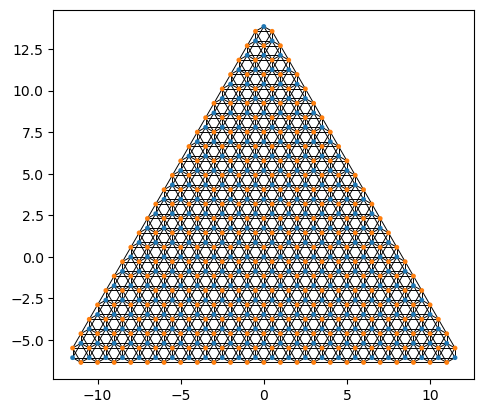

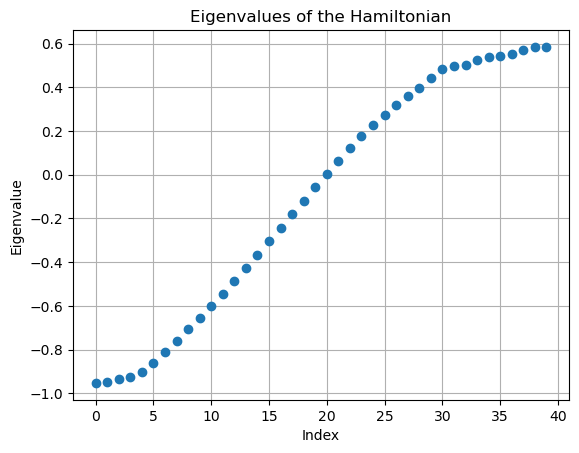

In [30]:
triangular_dot = create_graphene_tiangular_system(15, np.pi/2)
system_parameters = SimpleNamespace(U_imp = 0.0, m = 0.0, B = 0.0, t_prime = 0.0, p = 0.0, t2 = 0.15*np.exp(-1j*np.pi/3))
h = triangular_dot.finalized().hamiltonian_submatrix(sparse=False, params=dict(param=system_parameters))
N = len(h)
eigenvalues, eigenvectors = np.linalg.eigh(h)
eigenstates = eigenvectors.T
i_0 = binary_search(eigenvalues, 0.0)
kwant.plot(triangular_dot, show=False)
plt.show()
plt.plot(np.sort(eigenvalues)[i_0-40//2:i_0+40//2], 'o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Hamiltonian')
plt.grid()
plt.show()

## Bott index

In [37]:
system_parameters = SimpleNamespace(U_imp = 0.0, m = 0.0, B = 0.0, t_prime = 0.0, p = 0.0, t2 = 0.15*np.exp(1j*np.pi/3))
h = triangular_dot.finalized().hamiltonian_submatrix(sparse=False, params=dict(param=system_parameters))
N = len(h)
eigenvalues, eigenvectors = np.linalg.eigh(h)
eigenstates = eigenvectors.T
i_0 = binary_search(eigenvalues, 0.0)

P = np.zeros([len(eigenstates[0]),len(eigenstates[0])], dtype=complex)
N_occ = binary_search(eigenvalues, 0.0)
for i in range(N_occ):
    P += np.array([eigenstates[i]]).T@np.array([eigenstates[i]]).conj()

x_positions = np.array([s.pos[0] for s in triangular_dot.finalized().sites])
x_norm = (x_positions-min(x_positions))/(max(x_positions)-min(x_positions))
y_positions = np.array([s.pos[1] for s in triangular_dot.finalized().sites])
y_norm = (y_positions-min(y_positions))/(max(y_positions)-min(y_positions))

X = np.diag(x_norm)
# X = np.diag(x_positions - min(x_positions))
Y = np.diag(y_norm)
# Y = np.diag(y_positions - min(y_positions))

pXp = P@X@P
pYp = P@Y@P

U = la.expm(1j*2*np.pi*pXp)
V = la.expm(1j*2*np.pi*pYp)
UVUdVd = U@V@np.conj(U.T)@np.conj(V.T)
bott = np.imag(np.sum(np.log(np.linalg.eigvals(UVUdVd))))/2/np.pi

print("Bott index:", bott)

Bott index: -4.505926742051863e-15
